<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:03:55] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


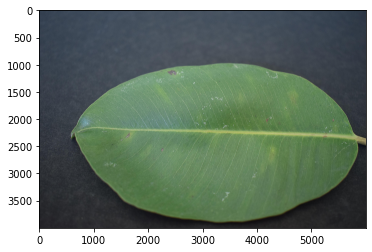

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

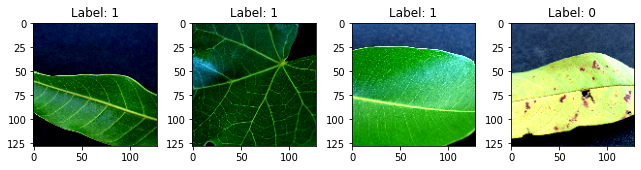

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:04:00] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:04:02] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.209200530320257 samples/sec                   batch loss = 1.0448631048202515 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2732920767826903 samples/sec                   batch loss = 0.6696924567222595 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2627732875066762 samples/sec                   batch loss = 0.9844442009925842 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.2678209025964566 samples/sec                   batch loss = 1.0327523946762085 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.273813541518217 samples/sec                   batch loss = 0.44932758808135986 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.2603358112782415 samples/sec                   batch loss = 0.5772289633750916 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.2669441115458302 samples/sec                   batch loss = 0.9167150855064392 | accuracy = 0.5571428571428572


Epoch[1] Batch[40] Speed: 1.2734856668858823 samples/sec                   batch loss = 0.42047035694122314 | accuracy = 0.56875


Epoch[1] Batch[45] Speed: 1.2760539022202535 samples/sec                   batch loss = 0.7497280836105347 | accuracy = 0.5666666666666667


Epoch[1] Batch[50] Speed: 1.2782597909767006 samples/sec                   batch loss = 0.5784137845039368 | accuracy = 0.58


Epoch[1] Batch[55] Speed: 1.2695696761318525 samples/sec                   batch loss = 0.6689782738685608 | accuracy = 0.5909090909090909


Epoch[1] Batch[60] Speed: 1.2720827715867817 samples/sec                   batch loss = 0.6626825332641602 | accuracy = 0.6083333333333333


Epoch[1] Batch[65] Speed: 1.2688673041450973 samples/sec                   batch loss = 0.39541295170783997 | accuracy = 0.6076923076923076


Epoch[1] Batch[70] Speed: 1.2754554504055147 samples/sec                   batch loss = 0.7924888730049133 | accuracy = 0.6142857142857143


Epoch[1] Batch[75] Speed: 1.274854072235127 samples/sec                   batch loss = 0.6041094660758972 | accuracy = 0.6133333333333333


Epoch[1] Batch[80] Speed: 1.2673462623095757 samples/sec                   batch loss = 0.30657702684402466 | accuracy = 0.628125


Epoch[1] Batch[85] Speed: 1.277325521727121 samples/sec                   batch loss = 0.8168085217475891 | accuracy = 0.6352941176470588


Epoch[1] Batch[90] Speed: 1.275790064098177 samples/sec                   batch loss = 0.4905109703540802 | accuracy = 0.6416666666666667


Epoch[1] Batch[95] Speed: 1.2708048150134372 samples/sec                   batch loss = 0.4985458254814148 | accuracy = 0.6473684210526316


Epoch[1] Batch[100] Speed: 1.2744580831218253 samples/sec                   batch loss = 1.0691759586334229 | accuracy = 0.645


Epoch[1] Batch[105] Speed: 1.2717918427167678 samples/sec                   batch loss = 0.6741193532943726 | accuracy = 0.6452380952380953


Epoch[1] Batch[110] Speed: 1.271838795048891 samples/sec                   batch loss = 0.38880932331085205 | accuracy = 0.6522727272727272


Epoch[1] Batch[115] Speed: 1.2706557285295688 samples/sec                   batch loss = 0.32158732414245605 | accuracy = 0.6565217391304348


Epoch[1] Batch[120] Speed: 1.2715768896585302 samples/sec                   batch loss = 1.368626594543457 | accuracy = 0.6520833333333333


Epoch[1] Batch[125] Speed: 1.2669742496481826 samples/sec                   batch loss = 0.7421923875808716 | accuracy = 0.656


Epoch[1] Batch[130] Speed: 1.2727038391739374 samples/sec                   batch loss = 0.3882473409175873 | accuracy = 0.6596153846153846


Epoch[1] Batch[135] Speed: 1.2736650052879535 samples/sec                   batch loss = 0.3452495038509369 | accuracy = 0.6648148148148149


Epoch[1] Batch[140] Speed: 1.2719458246150532 samples/sec                   batch loss = 0.5977869629859924 | accuracy = 0.6660714285714285


Epoch[1] Batch[145] Speed: 1.2725988056673267 samples/sec                   batch loss = 1.4609007835388184 | accuracy = 0.6655172413793103


Epoch[1] Batch[150] Speed: 1.2715825758215973 samples/sec                   batch loss = 0.21430739760398865 | accuracy = 0.6683333333333333


Epoch[1] Batch[155] Speed: 1.272697660252435 samples/sec                   batch loss = 0.9950388669967651 | accuracy = 0.6645161290322581


Epoch[1] Batch[160] Speed: 1.2720066755797728 samples/sec                   batch loss = 0.7926741242408752 | accuracy = 0.6671875


Epoch[1] Batch[165] Speed: 1.2728439430114356 samples/sec                   batch loss = 0.4963366985321045 | accuracy = 0.6636363636363637


Epoch[1] Batch[170] Speed: 1.2695364363692496 samples/sec                   batch loss = 0.39665156602859497 | accuracy = 0.6647058823529411


Epoch[1] Batch[175] Speed: 1.2682860231267017 samples/sec                   batch loss = 0.8097988367080688 | accuracy = 0.6671428571428571


Epoch[1] Batch[180] Speed: 1.2645219739614484 samples/sec                   batch loss = 0.8885716795921326 | accuracy = 0.6666666666666666


Epoch[1] Batch[185] Speed: 1.2707734356099505 samples/sec                   batch loss = 0.3329256474971771 | accuracy = 0.6675675675675675


Epoch[1] Batch[190] Speed: 1.2703881535955754 samples/sec                   batch loss = 0.6477673649787903 | accuracy = 0.6684210526315789


Epoch[1] Batch[195] Speed: 1.2675390061464689 samples/sec                   batch loss = 0.23861590027809143 | accuracy = 0.6705128205128205


Epoch[1] Batch[200] Speed: 1.2681925499239033 samples/sec                   batch loss = 0.2686375081539154 | accuracy = 0.6675


Epoch[1] Batch[205] Speed: 1.2761519353530153 samples/sec                   batch loss = 1.062286138534546 | accuracy = 0.6621951219512195


Epoch[1] Batch[210] Speed: 1.2727312588619515 samples/sec                   batch loss = 0.37211647629737854 | accuracy = 0.6654761904761904


Epoch[1] Batch[215] Speed: 1.2767163555099035 samples/sec                   batch loss = 1.4635953903198242 | accuracy = 0.6627906976744186


Epoch[1] Batch[220] Speed: 1.2715425810079746 samples/sec                   batch loss = 0.5284274816513062 | accuracy = 0.6636363636363637


Epoch[1] Batch[225] Speed: 1.2772228354788857 samples/sec                   batch loss = 0.6503092646598816 | accuracy = 0.6633333333333333


Epoch[1] Batch[230] Speed: 1.2658502564526635 samples/sec                   batch loss = 1.8311259746551514 | accuracy = 0.658695652173913


Epoch[1] Batch[235] Speed: 1.2722526460876364 samples/sec                   batch loss = 1.41011643409729 | accuracy = 0.6574468085106383


Epoch[1] Batch[240] Speed: 1.2698480554060492 samples/sec                   batch loss = 0.6881650686264038 | accuracy = 0.6583333333333333


Epoch[1] Batch[245] Speed: 1.273069660986301 samples/sec                   batch loss = 0.5329005718231201 | accuracy = 0.6612244897959184


Epoch[1] Batch[250] Speed: 1.2742389374212961 samples/sec                   batch loss = 0.4390203654766083 | accuracy = 0.663


Epoch[1] Batch[255] Speed: 1.2675250247408603 samples/sec                   batch loss = 1.3737467527389526 | accuracy = 0.6647058823529411


Epoch[1] Batch[260] Speed: 1.264674200390501 samples/sec                   batch loss = 0.6803882718086243 | accuracy = 0.6644230769230769


Epoch[1] Batch[265] Speed: 1.2658278122111237 samples/sec                   batch loss = 0.6936413049697876 | accuracy = 0.6622641509433962


Epoch[1] Batch[270] Speed: 1.264787273917568 samples/sec                   batch loss = 0.725146472454071 | accuracy = 0.6620370370370371


Epoch[1] Batch[275] Speed: 1.2675392934388592 samples/sec                   batch loss = 0.4210403561592102 | accuracy = 0.6627272727272727


Epoch[1] Batch[280] Speed: 1.2651279514496339 samples/sec                   batch loss = 0.42360982298851013 | accuracy = 0.6625


Epoch[1] Batch[285] Speed: 1.267694450354953 samples/sec                   batch loss = 0.33811283111572266 | accuracy = 0.6640350877192982


Epoch[1] Batch[290] Speed: 1.2638564972966084 samples/sec                   batch loss = 0.7102397084236145 | accuracy = 0.6629310344827586


Epoch[1] Batch[295] Speed: 1.2636790536049263 samples/sec                   batch loss = 1.9555823802947998 | accuracy = 0.6635593220338983


Epoch[1] Batch[300] Speed: 1.2668368698016996 samples/sec                   batch loss = 0.43556642532348633 | accuracy = 0.6616666666666666


Epoch[1] Batch[305] Speed: 1.2670094604219269 samples/sec                   batch loss = 0.699705183506012 | accuracy = 0.6631147540983606


Epoch[1] Batch[310] Speed: 1.2673900147088475 samples/sec                   batch loss = 0.16306456923484802 | accuracy = 0.6629032258064517


Epoch[1] Batch[315] Speed: 1.2702128141222648 samples/sec                   batch loss = 0.7373859882354736 | accuracy = 0.6642857142857143


Epoch[1] Batch[320] Speed: 1.2700883842044737 samples/sec                   batch loss = 0.3200514614582062 | accuracy = 0.665625


Epoch[1] Batch[325] Speed: 1.2663328568575454 samples/sec                   batch loss = 0.6535134315490723 | accuracy = 0.6676923076923077


Epoch[1] Batch[330] Speed: 1.2625120618881058 samples/sec                   batch loss = 0.8841007351875305 | accuracy = 0.6681818181818182


Epoch[1] Batch[335] Speed: 1.2658998276189122 samples/sec                   batch loss = 0.3828171491622925 | accuracy = 0.6686567164179105


Epoch[1] Batch[340] Speed: 1.2690364168748733 samples/sec                   batch loss = 0.5887934565544128 | accuracy = 0.6698529411764705


Epoch[1] Batch[345] Speed: 1.2646657159244745 samples/sec                   batch loss = 0.8400765657424927 | accuracy = 0.6710144927536232


Epoch[1] Batch[350] Speed: 1.2724573081545207 samples/sec                   batch loss = 0.8818119168281555 | accuracy = 0.6735714285714286


Epoch[1] Batch[355] Speed: 1.2753328996380586 samples/sec                   batch loss = 0.45866817235946655 | accuracy = 0.673943661971831


Epoch[1] Batch[360] Speed: 1.274637308169631 samples/sec                   batch loss = 0.2877575159072876 | accuracy = 0.675


Epoch[1] Batch[365] Speed: 1.265514153669925 samples/sec                   batch loss = 0.44288697838783264 | accuracy = 0.673972602739726


Epoch[1] Batch[370] Speed: 1.2672677644829384 samples/sec                   batch loss = 0.28388839960098267 | accuracy = 0.6763513513513514


Epoch[1] Batch[375] Speed: 1.267475804986358 samples/sec                   batch loss = 0.548841118812561 | accuracy = 0.6786666666666666


Epoch[1] Batch[380] Speed: 1.2674090675730272 samples/sec                   batch loss = 0.7899444103240967 | accuracy = 0.6796052631578947


Epoch[1] Batch[385] Speed: 1.2623810621652027 samples/sec                   batch loss = 0.5480133295059204 | accuracy = 0.6785714285714286


Epoch[1] Batch[390] Speed: 1.2715030705301107 samples/sec                   batch loss = 0.4785737991333008 | accuracy = 0.6788461538461539


Epoch[1] Batch[395] Speed: 1.268675787070593 samples/sec                   batch loss = 0.6348881125450134 | accuracy = 0.6810126582278481


Epoch[1] Batch[400] Speed: 1.2644657442875742 samples/sec                   batch loss = 0.42638295888900757 | accuracy = 0.681875


Epoch[1] Batch[405] Speed: 1.2657685059393482 samples/sec                   batch loss = 0.7807360887527466 | accuracy = 0.6790123456790124


Epoch[1] Batch[410] Speed: 1.264153427083579 samples/sec                   batch loss = 0.37735599279403687 | accuracy = 0.6792682926829269


Epoch[1] Batch[415] Speed: 1.2650630826815945 samples/sec                   batch loss = 0.615367591381073 | accuracy = 0.6795180722891566


Epoch[1] Batch[420] Speed: 1.2637928060328625 samples/sec                   batch loss = 1.3750046491622925 | accuracy = 0.680952380952381


Epoch[1] Batch[425] Speed: 1.2686735805474472 samples/sec                   batch loss = 0.7148758172988892 | accuracy = 0.6817647058823529


Epoch[1] Batch[430] Speed: 1.261157685302925 samples/sec                   batch loss = 0.5402230024337769 | accuracy = 0.6813953488372093


Epoch[1] Batch[435] Speed: 1.2652456861763526 samples/sec                   batch loss = 0.4370582699775696 | accuracy = 0.6827586206896552


Epoch[1] Batch[440] Speed: 1.2688674960749715 samples/sec                   batch loss = 0.33784183859825134 | accuracy = 0.6846590909090909


Epoch[1] Batch[445] Speed: 1.2672905469968614 samples/sec                   batch loss = 0.581636369228363 | accuracy = 0.6842696629213483


Epoch[1] Batch[450] Speed: 1.2662390023460253 samples/sec                   batch loss = 0.261639803647995 | accuracy = 0.6855555555555556


Epoch[1] Batch[455] Speed: 1.2637515862601232 samples/sec                   batch loss = 0.32498854398727417 | accuracy = 0.6862637362637363


Epoch[1] Batch[460] Speed: 1.2681107841543295 samples/sec                   batch loss = 0.7275067567825317 | accuracy = 0.6853260869565218


Epoch[1] Batch[465] Speed: 1.2643604462320253 samples/sec                   batch loss = 0.508665919303894 | accuracy = 0.6870967741935484


Epoch[1] Batch[470] Speed: 1.2639719005117676 samples/sec                   batch loss = 0.6241133213043213 | accuracy = 0.6888297872340425


Epoch[1] Batch[475] Speed: 1.2651219412694477 samples/sec                   batch loss = 0.36085858941078186 | accuracy = 0.6889473684210526


Epoch[1] Batch[480] Speed: 1.2686584229002562 samples/sec                   batch loss = 1.0142148733139038 | accuracy = 0.6864583333333333


Epoch[1] Batch[485] Speed: 1.2697236008434543 samples/sec                   batch loss = 0.7126932144165039 | accuracy = 0.6860824742268041


Epoch[1] Batch[490] Speed: 1.2668706379910712 samples/sec                   batch loss = 0.385457843542099 | accuracy = 0.6887755102040817


Epoch[1] Batch[495] Speed: 1.2672346451463883 samples/sec                   batch loss = 0.29108068346977234 | accuracy = 0.6888888888888889


Epoch[1] Batch[500] Speed: 1.2683046235409337 samples/sec                   batch loss = 0.7067093253135681 | accuracy = 0.6885


Epoch[1] Batch[505] Speed: 1.2669118701476227 samples/sec                   batch loss = 0.3499024212360382 | accuracy = 0.6886138613861386


Epoch[1] Batch[510] Speed: 1.2670157756046303 samples/sec                   batch loss = 0.23208992183208466 | accuracy = 0.6901960784313725


Epoch[1] Batch[515] Speed: 1.265793908589535 samples/sec                   batch loss = 0.7427217960357666 | accuracy = 0.6922330097087379


Epoch[1] Batch[520] Speed: 1.2715005650704034 samples/sec                   batch loss = 0.8227173686027527 | accuracy = 0.6908653846153846


Epoch[1] Batch[525] Speed: 1.2662293500742845 samples/sec                   batch loss = 0.3415801525115967 | accuracy = 0.6914285714285714


Epoch[1] Batch[530] Speed: 1.2652892936575937 samples/sec                   batch loss = 0.6118553876876831 | accuracy = 0.6919811320754717


Epoch[1] Batch[535] Speed: 1.265697842275876 samples/sec                   batch loss = 0.31245237588882446 | accuracy = 0.6906542056074766


Epoch[1] Batch[540] Speed: 1.26574596910328 samples/sec                   batch loss = 0.8158489465713501 | accuracy = 0.6921296296296297


Epoch[1] Batch[545] Speed: 1.2703704539427922 samples/sec                   batch loss = 1.0198783874511719 | accuracy = 0.691743119266055


Epoch[1] Batch[550] Speed: 1.2732336150596166 samples/sec                   batch loss = 0.40584057569503784 | accuracy = 0.6909090909090909


Epoch[1] Batch[555] Speed: 1.2732783547060262 samples/sec                   batch loss = 0.2847523093223572 | accuracy = 0.6905405405405406


Epoch[1] Batch[560] Speed: 1.275836341894186 samples/sec                   batch loss = 0.4829608201980591 | accuracy = 0.6901785714285714


Epoch[1] Batch[565] Speed: 1.2783872883748415 samples/sec                   batch loss = 0.4042946398258209 | accuracy = 0.6911504424778762


Epoch[1] Batch[570] Speed: 1.2716761638791012 samples/sec                   batch loss = 0.9706188440322876 | accuracy = 0.6916666666666667


Epoch[1] Batch[575] Speed: 1.2758497310651076 samples/sec                   batch loss = 0.33808434009552 | accuracy = 0.6926086956521739


Epoch[1] Batch[580] Speed: 1.2639510463906327 samples/sec                   batch loss = 0.43139034509658813 | accuracy = 0.6926724137931034


Epoch[1] Batch[585] Speed: 1.2644978613024167 samples/sec                   batch loss = 0.50461345911026 | accuracy = 0.6935897435897436


Epoch[1] Batch[590] Speed: 1.2696586442911353 samples/sec                   batch loss = 0.7946503162384033 | accuracy = 0.6940677966101695


Epoch[1] Batch[595] Speed: 1.268556933556963 samples/sec                   batch loss = 0.561147928237915 | accuracy = 0.6949579831932773


Epoch[1] Batch[600] Speed: 1.2784660981857248 samples/sec                   batch loss = 0.23096895217895508 | accuracy = 0.6958333333333333


Epoch[1] Batch[605] Speed: 1.2657896110770595 samples/sec                   batch loss = 0.4976455867290497 | accuracy = 0.6966942148760331


Epoch[1] Batch[610] Speed: 1.2638633523443998 samples/sec                   batch loss = 0.3735416829586029 | accuracy = 0.6975409836065574


Epoch[1] Batch[615] Speed: 1.2680693780795749 samples/sec                   batch loss = 0.49022698402404785 | accuracy = 0.6967479674796748


Epoch[1] Batch[620] Speed: 1.2659416652657003 samples/sec                   batch loss = 1.0349349975585938 | accuracy = 0.6967741935483871


Epoch[1] Batch[625] Speed: 1.2631420760933734 samples/sec                   batch loss = 0.49345043301582336 | accuracy = 0.6984


Epoch[1] Batch[630] Speed: 1.2773706466638952 samples/sec                   batch loss = 0.7083267569541931 | accuracy = 0.6984126984126984


Epoch[1] Batch[635] Speed: 1.268497467196187 samples/sec                   batch loss = 0.684629499912262 | accuracy = 0.6988188976377953


Epoch[1] Batch[640] Speed: 1.2655220767661224 samples/sec                   batch loss = 0.13696223497390747 | accuracy = 0.6984375


Epoch[1] Batch[645] Speed: 1.2670919454939211 samples/sec                   batch loss = 0.3778018355369568 | accuracy = 0.6988372093023256


Epoch[1] Batch[650] Speed: 1.2668324695469915 samples/sec                   batch loss = 0.8715606927871704 | accuracy = 0.6976923076923077


Epoch[1] Batch[655] Speed: 1.2660001279792914 samples/sec                   batch loss = 0.5419323444366455 | accuracy = 0.6969465648854962


Epoch[1] Batch[660] Speed: 1.2672775283171736 samples/sec                   batch loss = 0.4897274076938629 | accuracy = 0.6977272727272728


Epoch[1] Batch[665] Speed: 1.26882920721468 samples/sec                   batch loss = 1.5920181274414062 | accuracy = 0.6966165413533835


Epoch[1] Batch[670] Speed: 1.2700085849567426 samples/sec                   batch loss = 0.49832454323768616 | accuracy = 0.6970149253731344


Epoch[1] Batch[675] Speed: 1.261967627189911 samples/sec                   batch loss = 0.43658843636512756 | accuracy = 0.6977777777777778


Epoch[1] Batch[680] Speed: 1.2751394259643531 samples/sec                   batch loss = 0.9544788599014282 | accuracy = 0.6981617647058823


Epoch[1] Batch[685] Speed: 1.2734921434584814 samples/sec                   batch loss = 0.4873090088367462 | accuracy = 0.6985401459854015


Epoch[1] Batch[690] Speed: 1.2720926097579932 samples/sec                   batch loss = 0.7776626348495483 | accuracy = 0.6992753623188406


Epoch[1] Batch[695] Speed: 1.2631532980961995 samples/sec                   batch loss = 0.4700978994369507 | accuracy = 0.6992805755395683


Epoch[1] Batch[700] Speed: 1.2664817910390074 samples/sec                   batch loss = 1.1287052631378174 | accuracy = 0.6996428571428571


Epoch[1] Batch[705] Speed: 1.2627262418109566 samples/sec                   batch loss = 2.91628098487854 | accuracy = 0.699645390070922


Epoch[1] Batch[710] Speed: 1.2756410665824818 samples/sec                   batch loss = 0.32695916295051575 | accuracy = 0.7003521126760563


Epoch[1] Batch[715] Speed: 1.2761922206599754 samples/sec                   batch loss = 0.5071008205413818 | accuracy = 0.7006993006993008


Epoch[1] Batch[720] Speed: 1.2747012255649637 samples/sec                   batch loss = 0.46494513750076294 | accuracy = 0.7010416666666667


Epoch[1] Batch[725] Speed: 1.2684903699707126 samples/sec                   batch loss = 0.18270453810691833 | accuracy = 0.7017241379310345


Epoch[1] Batch[730] Speed: 1.271059565310347 samples/sec                   batch loss = 0.3785913288593292 | accuracy = 0.7027397260273973


Epoch[1] Batch[735] Speed: 1.2716908153679094 samples/sec                   batch loss = 0.4276105761528015 | accuracy = 0.7020408163265306


Epoch[1] Batch[740] Speed: 1.2681346513842422 samples/sec                   batch loss = 0.975018322467804 | accuracy = 0.702027027027027


Epoch[1] Batch[745] Speed: 1.2679336771228094 samples/sec                   batch loss = 0.5528281927108765 | accuracy = 0.7013422818791947


Epoch[1] Batch[750] Speed: 1.2674139505600852 samples/sec                   batch loss = 0.9809503555297852 | accuracy = 0.701


Epoch[1] Batch[755] Speed: 1.273355279460961 samples/sec                   batch loss = 1.4552029371261597 | accuracy = 0.7009933774834437


Epoch[1] Batch[760] Speed: 1.2680466633955005 samples/sec                   batch loss = 0.837117612361908 | accuracy = 0.7013157894736842


Epoch[1] Batch[765] Speed: 1.2660637553033707 samples/sec                   batch loss = 0.41726434230804443 | accuracy = 0.7022875816993464


Epoch[1] Batch[770] Speed: 1.2673494215720083 samples/sec                   batch loss = 0.7342260479927063 | accuracy = 0.7022727272727273


Epoch[1] Batch[775] Speed: 1.2685773644160654 samples/sec                   batch loss = 0.21431012451648712 | accuracy = 0.7029032258064516


Epoch[1] Batch[780] Speed: 1.2689404336306258 samples/sec                   batch loss = 0.3063456118106842 | accuracy = 0.7032051282051283


Epoch[1] Batch[785] Speed: 1.272098975714573 samples/sec                   batch loss = 0.5618208646774292 | accuracy = 0.7038216560509554


[Epoch 1] training: accuracy=0.7043147208121827
[Epoch 1] time cost: 649.2485134601593
[Epoch 1] validation: validation accuracy=0.7577777777777778


Epoch[2] Batch[5] Speed: 1.2753037197387216 samples/sec                   batch loss = 0.6689902544021606 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2707379190751007 samples/sec                   batch loss = 0.41288796067237854 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.272162060000963 samples/sec                   batch loss = 0.4329558312892914 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2716020440870432 samples/sec                   batch loss = 0.674357533454895 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2732990345683677 samples/sec                   batch loss = 1.4349116086959839 | accuracy = 0.7


Epoch[2] Batch[30] Speed: 1.2789115708486316 samples/sec                   batch loss = 0.2439461201429367 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2702570531975472 samples/sec                   batch loss = 0.5963858962059021 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.2724267156265672 samples/sec                   batch loss = 0.17209172248840332 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2735726711235442 samples/sec                   batch loss = 0.3474811315536499 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.2692522402274624 samples/sec                   batch loss = 0.1628710776567459 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.277112874482438 samples/sec                   batch loss = 0.7008799314498901 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2730344023689957 samples/sec                   batch loss = 0.5219678282737732 | accuracy = 0.7333333333333333


Epoch[2] Batch[65] Speed: 1.2741441976682026 samples/sec                   batch loss = 0.6541683077812195 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.2735420249414267 samples/sec                   batch loss = 0.6031436920166016 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.2733915223591679 samples/sec                   batch loss = 0.4556507468223572 | accuracy = 0.7466666666666667


Epoch[2] Batch[80] Speed: 1.2770892513812437 samples/sec                   batch loss = 0.8445204496383667 | accuracy = 0.74375


Epoch[2] Batch[85] Speed: 1.2757759970897138 samples/sec                   batch loss = 0.39436906576156616 | accuracy = 0.7529411764705882


Epoch[2] Batch[90] Speed: 1.2700783847130468 samples/sec                   batch loss = 0.28983157873153687 | accuracy = 0.7555555555555555


Epoch[2] Batch[95] Speed: 1.27243096182013 samples/sec                   batch loss = 0.18974067270755768 | accuracy = 0.7605263157894737


Epoch[2] Batch[100] Speed: 1.2711340071057424 samples/sec                   batch loss = 0.21948106586933136 | accuracy = 0.7675


Epoch[2] Batch[105] Speed: 1.2738283390166538 samples/sec                   batch loss = 0.45405614376068115 | accuracy = 0.7666666666666667


Epoch[2] Batch[110] Speed: 1.2669224895367157 samples/sec                   batch loss = 0.5244120955467224 | accuracy = 0.7681818181818182


Epoch[2] Batch[115] Speed: 1.2734719406363406 samples/sec                   batch loss = 0.20069345831871033 | accuracy = 0.7760869565217391


Epoch[2] Batch[120] Speed: 1.27028734912456 samples/sec                   batch loss = 0.2988535761833191 | accuracy = 0.7770833333333333


Epoch[2] Batch[125] Speed: 1.2745935381363094 samples/sec                   batch loss = 0.23563282191753387 | accuracy = 0.776


Epoch[2] Batch[130] Speed: 1.2741910335381263 samples/sec                   batch loss = 0.29623040556907654 | accuracy = 0.7730769230769231


Epoch[2] Batch[135] Speed: 1.274143133256629 samples/sec                   batch loss = 0.5076894164085388 | accuracy = 0.774074074074074


Epoch[2] Batch[140] Speed: 1.2679634790105885 samples/sec                   batch loss = 0.3162916898727417 | accuracy = 0.775


Epoch[2] Batch[145] Speed: 1.267593689811419 samples/sec                   batch loss = 0.20816920697689056 | accuracy = 0.7724137931034483


Epoch[2] Batch[150] Speed: 1.2687438093101926 samples/sec                   batch loss = 0.9343914985656738 | accuracy = 0.77


Epoch[2] Batch[155] Speed: 1.2739073615438006 samples/sec                   batch loss = 0.8245300650596619 | accuracy = 0.7596774193548387


Epoch[2] Batch[160] Speed: 1.2676431102817929 samples/sec                   batch loss = 0.6270216703414917 | accuracy = 0.7609375


Epoch[2] Batch[165] Speed: 1.2697074571743185 samples/sec                   batch loss = 0.3414105772972107 | accuracy = 0.7621212121212121


Epoch[2] Batch[170] Speed: 1.2700406957374586 samples/sec                   batch loss = 0.2734644412994385 | accuracy = 0.7661764705882353


Epoch[2] Batch[175] Speed: 1.2757454387954235 samples/sec                   batch loss = 0.2932000756263733 | accuracy = 0.7657142857142857


Epoch[2] Batch[180] Speed: 1.2766087159058284 samples/sec                   batch loss = 0.09000292420387268 | accuracy = 0.7638888888888888


Epoch[2] Batch[185] Speed: 1.2656452316183182 samples/sec                   batch loss = 0.560225784778595 | accuracy = 0.7621621621621621


Epoch[2] Batch[190] Speed: 1.274625687513699 samples/sec                   batch loss = 0.6117091178894043 | accuracy = 0.7605263157894737


Epoch[2] Batch[195] Speed: 1.2685596192661306 samples/sec                   batch loss = 0.2727421224117279 | accuracy = 0.764102564102564


Epoch[2] Batch[200] Speed: 1.2656871479223482 samples/sec                   batch loss = 0.40461474657058716 | accuracy = 0.76375


Epoch[2] Batch[205] Speed: 1.2711572177797579 samples/sec                   batch loss = 0.19708164036273956 | accuracy = 0.7621951219512195


Epoch[2] Batch[210] Speed: 1.2738365599976735 samples/sec                   batch loss = 0.665134847164154 | accuracy = 0.7595238095238095


Epoch[2] Batch[215] Speed: 1.2776265770321535 samples/sec                   batch loss = 0.09055952727794647 | accuracy = 0.7604651162790698


Epoch[2] Batch[220] Speed: 1.2781919131270378 samples/sec                   batch loss = 0.447197288274765 | accuracy = 0.759090909090909


Epoch[2] Batch[225] Speed: 1.266965447260533 samples/sec                   batch loss = 0.3948855698108673 | accuracy = 0.7588888888888888


Epoch[2] Batch[230] Speed: 1.2772545342066393 samples/sec                   batch loss = 0.4001099467277527 | accuracy = 0.7597826086956522


Epoch[2] Batch[235] Speed: 1.2792572671658986 samples/sec                   batch loss = 0.5923439264297485 | accuracy = 0.7606382978723404


Epoch[2] Batch[240] Speed: 1.279150954185378 samples/sec                   batch loss = 0.5141736268997192 | accuracy = 0.759375


Epoch[2] Batch[245] Speed: 1.2736249760586336 samples/sec                   batch loss = 0.5303050875663757 | accuracy = 0.7591836734693878


Epoch[2] Batch[250] Speed: 1.2750181955833124 samples/sec                   batch loss = 0.4541286826133728 | accuracy = 0.758


Epoch[2] Batch[255] Speed: 1.2743578901122206 samples/sec                   batch loss = 0.21739421784877777 | accuracy = 0.7588235294117647


Epoch[2] Batch[260] Speed: 1.270425189790841 samples/sec                   batch loss = 0.2965618371963501 | accuracy = 0.760576923076923


Epoch[2] Batch[265] Speed: 1.2747450029947802 samples/sec                   batch loss = 0.48950451612472534 | accuracy = 0.7613207547169811


Epoch[2] Batch[270] Speed: 1.2730208790339947 samples/sec                   batch loss = 0.7179865837097168 | accuracy = 0.7592592592592593


Epoch[2] Batch[275] Speed: 1.2758950428803812 samples/sec                   batch loss = 0.30520138144493103 | accuracy = 0.7581818181818182


Epoch[2] Batch[280] Speed: 1.2714916033145813 samples/sec                   batch loss = 0.3732340633869171 | accuracy = 0.7571428571428571


Epoch[2] Batch[285] Speed: 1.2702587843544473 samples/sec                   batch loss = 0.39852553606033325 | accuracy = 0.7570175438596491


Epoch[2] Batch[290] Speed: 1.2713820488349312 samples/sec                   batch loss = 0.3784154951572418 | accuracy = 0.7577586206896552


Epoch[2] Batch[295] Speed: 1.27227049470794 samples/sec                   batch loss = 0.5225255489349365 | accuracy = 0.7576271186440678


Epoch[2] Batch[300] Speed: 1.2721087176805745 samples/sec                   batch loss = 0.38836053013801575 | accuracy = 0.7591666666666667


Epoch[2] Batch[305] Speed: 1.274281231317916 samples/sec                   batch loss = 0.28424468636512756 | accuracy = 0.7598360655737705


Epoch[2] Batch[310] Speed: 1.2759109561444242 samples/sec                   batch loss = 0.30990663170814514 | accuracy = 0.760483870967742


Epoch[2] Batch[315] Speed: 1.266867002802068 samples/sec                   batch loss = 0.24740643799304962 | accuracy = 0.7611111111111111


Epoch[2] Batch[320] Speed: 1.2737962298485859 samples/sec                   batch loss = 0.6804651618003845 | accuracy = 0.7625


Epoch[2] Batch[325] Speed: 1.266674654534168 samples/sec                   batch loss = 0.31107813119888306 | accuracy = 0.7607692307692308


Epoch[2] Batch[330] Speed: 1.2781336822094873 samples/sec                   batch loss = 0.4634152352809906 | accuracy = 0.7613636363636364


Epoch[2] Batch[335] Speed: 1.273024742814677 samples/sec                   batch loss = 0.3704465925693512 | accuracy = 0.7611940298507462


Epoch[2] Batch[340] Speed: 1.2685931915902662 samples/sec                   batch loss = 0.5088313221931458 | accuracy = 0.7602941176470588


Epoch[2] Batch[345] Speed: 1.2670912756182966 samples/sec                   batch loss = 0.5462873578071594 | accuracy = 0.7579710144927536


Epoch[2] Batch[350] Speed: 1.265132626073703 samples/sec                   batch loss = 0.21238622069358826 | accuracy = 0.7578571428571429


Epoch[2] Batch[355] Speed: 1.2679974031215446 samples/sec                   batch loss = 0.47076189517974854 | accuracy = 0.7591549295774648


Epoch[2] Batch[360] Speed: 1.266607427718543 samples/sec                   batch loss = 0.46471694111824036 | accuracy = 0.7604166666666666


Epoch[2] Batch[365] Speed: 1.2706999022201553 samples/sec                   batch loss = 0.34537965059280396 | accuracy = 0.760958904109589


Epoch[2] Batch[370] Speed: 1.267869478458701 samples/sec                   batch loss = 0.3574809432029724 | accuracy = 0.7621621621621621


Epoch[2] Batch[375] Speed: 1.2707924940812751 samples/sec                   batch loss = 0.6134372353553772 | accuracy = 0.7626666666666667


Epoch[2] Batch[380] Speed: 1.268937938259934 samples/sec                   batch loss = 0.25495660305023193 | accuracy = 0.7638157894736842


Epoch[2] Batch[385] Speed: 1.2654261471524506 samples/sec                   batch loss = 0.37033554911613464 | accuracy = 0.7636363636363637


Epoch[2] Batch[390] Speed: 1.2713107570282642 samples/sec                   batch loss = 0.3546470105648041 | accuracy = 0.764102564102564


Epoch[2] Batch[395] Speed: 1.2699838780661612 samples/sec                   batch loss = 0.32505765557289124 | accuracy = 0.7639240506329114


Epoch[2] Batch[400] Speed: 1.2681945630477036 samples/sec                   batch loss = 0.37395980954170227 | accuracy = 0.764375


Epoch[2] Batch[405] Speed: 1.262737646506201 samples/sec                   batch loss = 0.28605175018310547 | accuracy = 0.7666666666666667


Epoch[2] Batch[410] Speed: 1.268765109733875 samples/sec                   batch loss = 0.6150480508804321 | accuracy = 0.7664634146341464


Epoch[2] Batch[415] Speed: 1.2671569267961758 samples/sec                   batch loss = 0.11317073553800583 | accuracy = 0.766867469879518


Epoch[2] Batch[420] Speed: 1.2702232004109604 samples/sec                   batch loss = 0.36302974820137024 | accuracy = 0.7666666666666667


Epoch[2] Batch[425] Speed: 1.266674080733144 samples/sec                   batch loss = 1.5831764936447144 | accuracy = 0.7658823529411765


Epoch[2] Batch[430] Speed: 1.2671499402686637 samples/sec                   batch loss = 0.5692824125289917 | accuracy = 0.7645348837209303


Epoch[2] Batch[435] Speed: 1.2696199233545988 samples/sec                   batch loss = 0.4083365797996521 | accuracy = 0.764367816091954


Epoch[2] Batch[440] Speed: 1.2717482678840282 samples/sec                   batch loss = 0.48570939898490906 | accuracy = 0.7647727272727273


Epoch[2] Batch[445] Speed: 1.2722123196976758 samples/sec                   batch loss = 0.6405671834945679 | accuracy = 0.7646067415730337


Epoch[2] Batch[450] Speed: 1.2760864164909285 samples/sec                   batch loss = 0.4528316557407379 | accuracy = 0.7655555555555555


Epoch[2] Batch[455] Speed: 1.2769364514425612 samples/sec                   batch loss = 1.2602782249450684 | accuracy = 0.765934065934066


Epoch[2] Batch[460] Speed: 1.2768328560017146 samples/sec                   batch loss = 0.7656490206718445 | accuracy = 0.7657608695652174


Epoch[2] Batch[465] Speed: 1.2770728226614976 samples/sec                   batch loss = 0.42763715982437134 | accuracy = 0.7661290322580645


Epoch[2] Batch[470] Speed: 1.2785768769791985 samples/sec                   batch loss = 0.364422082901001 | accuracy = 0.7654255319148936


Epoch[2] Batch[475] Speed: 1.2738526153959928 samples/sec                   batch loss = 0.5785272717475891 | accuracy = 0.7642105263157895


Epoch[2] Batch[480] Speed: 1.2735896866753125 samples/sec                   batch loss = 0.3401168882846832 | accuracy = 0.7625


Epoch[2] Batch[485] Speed: 1.266414967070389 samples/sec                   batch loss = 0.36099401116371155 | accuracy = 0.7618556701030927


Epoch[2] Batch[490] Speed: 1.2704220151752026 samples/sec                   batch loss = 0.8958215713500977 | accuracy = 0.7607142857142857


Epoch[2] Batch[495] Speed: 1.267856160445634 samples/sec                   batch loss = 0.6979545950889587 | accuracy = 0.759090909090909


Epoch[2] Batch[500] Speed: 1.2701402110145334 samples/sec                   batch loss = 0.3543602228164673 | accuracy = 0.759


Epoch[2] Batch[505] Speed: 1.2673118943814095 samples/sec                   batch loss = 0.3235660493373871 | accuracy = 0.7584158415841584


Epoch[2] Batch[510] Speed: 1.2689183595381732 samples/sec                   batch loss = 0.14177973568439484 | accuracy = 0.7583333333333333


Epoch[2] Batch[515] Speed: 1.2675594999970157 samples/sec                   batch loss = 0.3885257840156555 | accuracy = 0.7582524271844661


Epoch[2] Batch[520] Speed: 1.2679610833086639 samples/sec                   batch loss = 0.5668942928314209 | accuracy = 0.7591346153846154


Epoch[2] Batch[525] Speed: 1.2720025286572179 samples/sec                   batch loss = 0.2652837932109833 | accuracy = 0.7595238095238095


Epoch[2] Batch[530] Speed: 1.2720141979734163 samples/sec                   batch loss = 0.4389897584915161 | accuracy = 0.7589622641509434


Epoch[2] Batch[535] Speed: 1.2721067885665482 samples/sec                   batch loss = 0.4059350788593292 | accuracy = 0.7598130841121495


Epoch[2] Batch[540] Speed: 1.2719480425352994 samples/sec                   batch loss = 0.32639819383621216 | accuracy = 0.7592592592592593


Epoch[2] Batch[545] Speed: 1.2738132513746254 samples/sec                   batch loss = 0.5358324646949768 | accuracy = 0.7587155963302752


Epoch[2] Batch[550] Speed: 1.268736613382734 samples/sec                   batch loss = 0.4907882809638977 | accuracy = 0.7581818181818182


Epoch[2] Batch[555] Speed: 1.2687041847491425 samples/sec                   batch loss = 0.39367949962615967 | accuracy = 0.7581081081081081


Epoch[2] Batch[560] Speed: 1.2799691413689673 samples/sec                   batch loss = 0.31461507081985474 | accuracy = 0.7589285714285714


Epoch[2] Batch[565] Speed: 1.2747808407396992 samples/sec                   batch loss = 0.6511812210083008 | accuracy = 0.7584070796460177


Epoch[2] Batch[570] Speed: 1.2653706005330674 samples/sec                   batch loss = 0.7271626591682434 | accuracy = 0.7592105263157894


Epoch[2] Batch[575] Speed: 1.2691339507229553 samples/sec                   batch loss = 0.11082470417022705 | accuracy = 0.7604347826086957


Epoch[2] Batch[580] Speed: 1.2715550128612834 samples/sec                   batch loss = 0.3756793439388275 | accuracy = 0.7573275862068966


Epoch[2] Batch[585] Speed: 1.2669976913857803 samples/sec                   batch loss = 0.36884236335754395 | accuracy = 0.7576923076923077


Epoch[2] Batch[590] Speed: 1.2685358319520532 samples/sec                   batch loss = 0.26417168974876404 | accuracy = 0.7572033898305085


Epoch[2] Batch[595] Speed: 1.2718697449910112 samples/sec                   batch loss = 0.4175384044647217 | accuracy = 0.7579831932773109


Epoch[2] Batch[600] Speed: 1.2725933034707209 samples/sec                   batch loss = 0.3984242379665375 | accuracy = 0.75875


Epoch[2] Batch[605] Speed: 1.272638094664486 samples/sec                   batch loss = 0.6469392776489258 | accuracy = 0.7586776859504132


Epoch[2] Batch[610] Speed: 1.2820831699577782 samples/sec                   batch loss = 0.16396406292915344 | accuracy = 0.7598360655737705


Epoch[2] Batch[615] Speed: 1.2751253733001746 samples/sec                   batch loss = 0.6271741986274719 | accuracy = 0.7597560975609756


Epoch[2] Batch[620] Speed: 1.2720210453578047 samples/sec                   batch loss = 0.6031896471977234 | accuracy = 0.7592741935483871


Epoch[2] Batch[625] Speed: 1.268922582348627 samples/sec                   batch loss = 0.5616495609283447 | accuracy = 0.7592


Epoch[2] Batch[630] Speed: 1.2669410499775644 samples/sec                   batch loss = 0.3188585340976715 | accuracy = 0.7591269841269841


Epoch[2] Batch[635] Speed: 1.2739358971788952 samples/sec                   batch loss = 0.23950450122356415 | accuracy = 0.760236220472441


Epoch[2] Batch[640] Speed: 1.2754489538480742 samples/sec                   batch loss = 0.14591577649116516 | accuracy = 0.76015625


Epoch[2] Batch[645] Speed: 1.2699121662332 samples/sec                   batch loss = 0.6928191781044006 | accuracy = 0.7600775193798449


Epoch[2] Batch[650] Speed: 1.2724009495597393 samples/sec                   batch loss = 0.26746347546577454 | accuracy = 0.7607692307692308


Epoch[2] Batch[655] Speed: 1.275795690988422 samples/sec                   batch loss = 0.2580498158931732 | accuracy = 0.7606870229007634


Epoch[2] Batch[660] Speed: 1.274426619851949 samples/sec                   batch loss = 0.377384215593338 | accuracy = 0.7609848484848485


Epoch[2] Batch[665] Speed: 1.2674855720266205 samples/sec                   batch loss = 0.5146995782852173 | accuracy = 0.7616541353383459


Epoch[2] Batch[670] Speed: 1.2702618619783652 samples/sec                   batch loss = 0.41605275869369507 | accuracy = 0.7626865671641792


Epoch[2] Batch[675] Speed: 1.264771732259632 samples/sec                   batch loss = 0.6767008900642395 | accuracy = 0.762962962962963


Epoch[2] Batch[680] Speed: 1.2690114598345306 samples/sec                   batch loss = 0.6531946063041687 | accuracy = 0.7625


Epoch[2] Batch[685] Speed: 1.2714902542439999 samples/sec                   batch loss = 0.6211921572685242 | accuracy = 0.7616788321167883


Epoch[2] Batch[690] Speed: 1.271305554966189 samples/sec                   batch loss = 0.26810213923454285 | accuracy = 0.7623188405797101


Epoch[2] Batch[695] Speed: 1.2823559886598908 samples/sec                   batch loss = 0.6870861649513245 | accuracy = 0.7618705035971223


Epoch[2] Batch[700] Speed: 1.2583323789271004 samples/sec                   batch loss = 0.2932732403278351 | accuracy = 0.7617857142857143


Epoch[2] Batch[705] Speed: 1.2725359676215557 samples/sec                   batch loss = 0.28485292196273804 | accuracy = 0.7617021276595745


Epoch[2] Batch[710] Speed: 1.2717829732609878 samples/sec                   batch loss = 0.814208447933197 | accuracy = 0.7605633802816901


Epoch[2] Batch[715] Speed: 1.2693966754901096 samples/sec                   batch loss = 0.17072440683841705 | accuracy = 0.7615384615384615


Epoch[2] Batch[720] Speed: 1.2682523711863907 samples/sec                   batch loss = 0.4194239377975464 | accuracy = 0.7618055555555555


Epoch[2] Batch[725] Speed: 1.276998364059577 samples/sec                   batch loss = 0.3357587158679962 | accuracy = 0.7620689655172413


Epoch[2] Batch[730] Speed: 1.2774283217524656 samples/sec                   batch loss = 0.06272149831056595 | accuracy = 0.7623287671232877


Epoch[2] Batch[735] Speed: 1.2746951240823028 samples/sec                   batch loss = 0.8740339875221252 | accuracy = 0.7629251700680272


Epoch[2] Batch[740] Speed: 1.2727047080895855 samples/sec                   batch loss = 0.8177185654640198 | accuracy = 0.7635135135135135


Epoch[2] Batch[745] Speed: 1.2712358129121404 samples/sec                   batch loss = 0.5882453322410583 | accuracy = 0.763758389261745


Epoch[2] Batch[750] Speed: 1.2779817030903649 samples/sec                   batch loss = 0.4413738548755646 | accuracy = 0.7646666666666667


Epoch[2] Batch[755] Speed: 1.2806429008703404 samples/sec                   batch loss = 0.13309131562709808 | accuracy = 0.7652317880794702


Epoch[2] Batch[760] Speed: 1.2769815488931422 samples/sec                   batch loss = 0.6959043145179749 | accuracy = 0.7644736842105263


Epoch[2] Batch[765] Speed: 1.2736282633884302 samples/sec                   batch loss = 0.19410468637943268 | accuracy = 0.765032679738562


Epoch[2] Batch[770] Speed: 1.270700672159206 samples/sec                   batch loss = 0.44655174016952515 | accuracy = 0.7655844155844156


Epoch[2] Batch[775] Speed: 1.2724884812339756 samples/sec                   batch loss = 0.4265894591808319 | accuracy = 0.765483870967742


Epoch[2] Batch[780] Speed: 1.272786005223992 samples/sec                   batch loss = 0.3128106892108917 | accuracy = 0.7657051282051283


Epoch[2] Batch[785] Speed: 1.2731190263318328 samples/sec                   batch loss = 0.31753432750701904 | accuracy = 0.7652866242038217


[Epoch 2] training: accuracy=0.7649111675126904
[Epoch 2] time cost: 637.1550951004028
[Epoch 2] validation: validation accuracy=0.8266666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8333333333333334

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)